In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
rng = np.random.default_rng()

In [42]:
def run_lattice_heatbath(U_state,beta,n):
    """Perform n heatbath updates on the lattice state U_state."""
    for _ in range(n):
        lattice_heatbath_update(U_state,beta)

def lattice_heatbath_update(U_state,beta):
    """Perform a random heatbath update on the lattice state U_state."""
    width = len(U_state)
    link_index = random_link_index(width)
    U_state[link_index] = sample_link_variable(U_state,beta,link_index)

def random_link_index(width):
    """Return a random link index (n_x,n_y,n_z,mu_index)"""
    return tuple(rng.integers(0,[width,width,width,width,4]))

def sample_link_variable(state,beta,link_index):
    """Sample angle theta defined via link variable angle U = exp(i*theta)."""
    link_variable_sum = relevant_link_variable_sum(state,link_index)
    alpha = -beta*np.abs(link_variable_sum)
    phi = np.angle(link_variable_sum)
    while True:
        Z = rng.uniform(0,1)
        x = -1 + np.log(1 + np.exp(2*alpha - 1)*Z)/alpha

        Q = np.exp(alpha*(np.cos(np.pi/2*(1-x))-x))
        Q_max = np.exp(0.2105137*alpha)

        Z_prime = rng.uniform(0,1)
        if Q/Q_max > Z_prime:
            theta = np.pi*(1-x)/2 - phi
            return np.exp(1j*theta)

def relevant_link_variable_sum(state,link_index):
    """Return the sum of the link variables present in the plaquettes containing the relevant link,
    without the contribution of the link itself."""
    link_variable_sum = 0
    for plaquette in get_plaquettes_with_link(state,link_index):
        link_variable_sum += sum(plaquette) - state[link_index]
    return link_variable_sum

def get_plaquettes_with_link(state,link_index):
    """Return the plaquettes that contain the relevant link."""
    vertex = link_index[:4]
    mu_index = link_index[-1]

    plaquettes = []
    for nu_index in range(4):
        if mu_index != nu_index:
            plaquettes.append(get_plaquette(state,vertex,mu_index,nu_index))

            nu = get_unit_vector(nu_index)
            plaquettes.append(get_plaquette(state,vertex-nu,mu_index,nu_index))

    return plaquettes

def get_plaquette(state,n,mu_index,nu_index):
    """Return the plaquette U_{mu nu}(n) as an array of the link variables."""
    width = len(state)
    mu = get_unit_vector(mu_index)
    nu = get_unit_vector(nu_index)
    return [
        state[get_lattice_vector(width,tuple(n))][mu_index],
        state[get_lattice_vector(width,tuple(n+mu))][nu_index],
        np.conj(state[get_lattice_vector(width,tuple(n+mu+nu))][nu_index]),
        np.conj(state[get_lattice_vector(width,tuple(n))][nu_index])
    ]

def get_unit_vector(index):
    """Return the unit vector from the dimension index."""
    vector = np.zeros(4).astype(int)
    vector[index] = 1
    return vector

def get_lattice_vector(width,vector):
    """Get the lattice vector periodic with the lattice width."""
    return tuple(map(lambda i: i % width, vector))

def lattice_action(U_state):
    """Compute action of the lattice state U_state."""
    action = 0
    plaquettes = unique_unoriented_plaquettes(len(U_state))
    for plaquette in plaquettes:
        action += 1 - np.real(plaquette_product(U_state,plaquette))
    return action

def get_unique_unoriented_plaquette_corners(width):
    """Return pairs of vertices forming the corners of only unique and unoriented lattice plaquettes."""
    unique_unoriented_corners = []
    for corners in get_plaquettes_corners(width):
        sorted_corners = tuple(sorted(corners))
        if sorted_corners not in unique_unoriented_corners:
            unique_unoriented_corners.append(sorted_corners)
    return unique_unoriented_corners

def get_plaquettes_corners(width):
    """Return pairs of vertices forming the corners of lattice plaquettes."""
    plaquette_corners = []
    for vertex in lattice_vertices(width):
        for mu_vector,nu_vector in get_plane_vectors():
            plaquette_corners.append([
                get_lattice_vector(width,vertex),
                get_lattice_vector(width,vertex + mu_vector),
                get_lattice_vector(width,vertex + nu_vector),
                get_lattice_vector(width,vertex + mu_vector + nu_vector)
            ])
    return plaquette_corners

def get_plane_vectors():
    """Return pairs of vectors (mu_vector,nu_vector) forming unique planes on the lattice."""
    plane_vectors = []
    for mu in range(4):
        for nu in range(4):
            if mu < nu:
                plane_vectors.append((get_unit_vector(mu),get_unit_vector(nu)))
    return plane_vectors

def lattice_vertices(width):
    """Compute the vertices of the lattice with given width."""
    vertices = []
    for n_x in range(width):
        for n_y in range(width):
            for n_z in range(width):
                for n_t in range(width):
                    vertex = (n_x,n_y,n_z,n_t)
                    vertices.append(vertex)
    return vertices

def plaquette_product(U_state,plaquette):
    """Compute the product of link variables around an elementary plaquette."""
    site_1, site_2, site_3, site_4 = plaquette
    U_12 = np.dot(U_state[site_1], U_state[site_2])
    U_23 = np.dot(U_state[site_2], U_state[site_3])
    U_34 = np.dot(U_state[site_3], U_state[site_4])
    U_41 = np.dot(U_state[site_4], U_state[site_1])
    return U_12*U_23*U_34*U_41

def ordered_state(width):
    return np.exp(2j * np.pi * np.zeros((width,width,width,width,4)))

def disordered_state(width):
    return np.exp(2j * np.pi * np.random.rand(width,width,width,width,4))

In [43]:
def run_simulation(U_state,beta,k,n,measurements):
    """Run the simulation with k equilibration sweeps and n measurement sweeps.
    Returns the action measurement results."""
    num_sites = len(U_state)**4

    # equilibrate
    run_lattice_heatbath(U_state,beta,k*num_sites)

    # measure
    results = np.empty(measurements)
    for i in range(measurements):
        run_lattice_heatbath(U_state,beta,n*num_sites)
        results[i] = lattice_action(U_state)

    return results

In [8]:
width = 4
beta = 0.55
equil_sweeps = 0
measure_sweeps = 1
measurements = 360

with h5py.File('lattice.hdf5','a') as f:
    if not "beta0.55-average-action-per-iterations" in f:
        U_state = ordered_state(width)
        action_measurements = run_simulation(U_state,beta,equil_sweeps,measure_sweeps,measurements)
        f.create_dataset("beta0.55-average-action-per-iterations",data=action_measurements)

Mean: -2.996478296757045


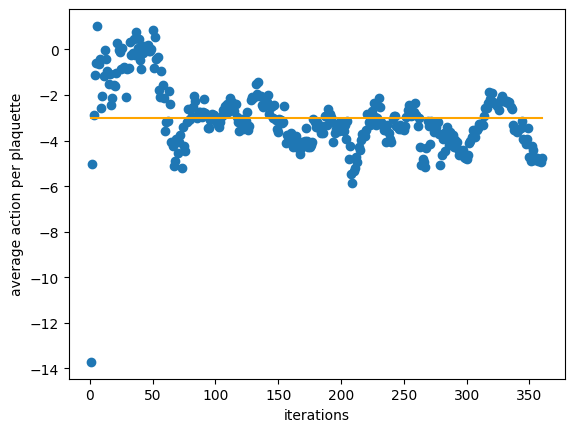

In [9]:
with h5py.File('lattice.hdf5','r') as f:
    action_measurements = f["beta0.55-average-action-per-iterations"][()]

    num_plaquettes = len(unique_unoriented_plaquettes(width))
    actions = [action / num_plaquettes for action in action_measurements]

    plt.scatter(np.linspace(1,measurements,measurements),actions)
    plt.xlabel("iterations")
    plt.ylabel("average action per plaquette")

    plt.plot(np.linspace(1,measurements,measurements),[np.mean(actions) for _ in range(measurements)],color="orange")

    print(f"Mean: {np.mean(actions)}")

In [10]:
width = 4
beta = 1.000
equil_sweeps = 0
measure_sweeps = 1
measurements = 360

with h5py.File('lattice.hdf5','a') as f:
    if not "beta1-average-action-per-iterations" in f:
        U_state = ordered_state(width)
        action_measurements = run_simulation(U_state,beta,equil_sweeps,measure_sweeps,measurements)
        f.create_dataset("beta1-average-action-per-iterations",data=action_measurements)

Mean: -12.611019771976263


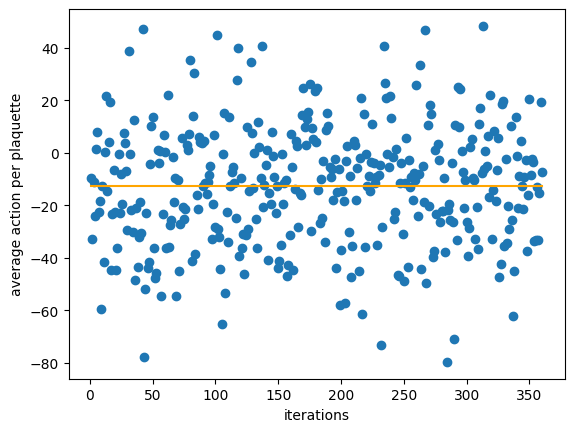

In [7]:
with h5py.File('lattice.hdf5','r') as f:
    action_measurements = f["beta1-average-action-per-iterations"][()]

    num_plaquettes = len(unique_unoriented_plaquettes(width))
    actions = [action / num_plaquettes for action in action_measurements]

    plt.scatter(np.linspace(1,measurements,measurements),actions)
    plt.xlabel("iterations")
    plt.ylabel("average action per plaquette")

    plt.plot(np.linspace(1,measurements,measurements),[np.mean(actions) for _ in range(measurements)],color="orange")

    print(f"Mean: {np.mean(actions)}")

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
False
False
True
False
True
False
True
True
True
False
True
False
True
True
True
False
True
False
True
True
True
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
False
False
True
False
True
False
True
True
True
False
True
False
True
True
True
False
True
False
True
True
True
False
False
False
False
False
